# **Build Your Own Image Classification in TensorFlow**

This assignment will help you guys understand the fundamentals of image classification, TensorFlow, and neural network architectures.

Credit: https://github.com/kaopanboonyuen/SC310005_ArtificialIntelligence_2023s1

![](https://github.com/kaopanboonyuen/SC310005_ArtificialIntelligence_2023s1/raw/main/img/sample_ai_project_v2.png)

## **Install TensorFlow with pip**

In [1]:
#!pip install tensorflow==2.9.1 # CPU Version
#!pip install tensorflow-gpu==2.9.1 # GPU Version

In [2]:
import tensorflow as tf
print(tf.__version__) ## 2.15.0

2.15.0


## **Download Sample Dataset**

In [3]:
# !wget https://github.com/kaopanboonyuen/SC310005_ArtificialIntelligence_2023s1/raw/main/dataset/MangoLeafBD_dataset_small_v2.zip

## **Download Sample Dataset (From Google Drive)**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# e.g., sample path: /content/drive/MyDrive/ML/Dataset/MangoLeafBD_dataset_small_v2.zip

### **Don't forget to uncomment** this line before training the model to unzip the dataset, which is currently in a zip file format.

In [6]:
# !unzip MangoLeafBD_dataset_small_v2.zip
# !unzip /content/drive/MyDrive/ML/Dataset/MangoLeafBD_dataset_small_v2.zip

# **Import Python Libraries (Deep Learning)**

In [7]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [8]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# **Data Preprocessing**

### **Read data and store it in dataframe**

In [9]:
def remove_ds_store(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename == '.DS_Store':
                file_path = os.path.join(dirpath, filename)
                os.remove(file_path)
                print(f"Removed: {file_path}")

### **Roor Directory of Dataset**

In [10]:
# Specify the root directory containing subfolders
root_directory = '/content/MangoLeafBD_dataset_small_v2/'

# Call the function to remove .DS_Store files
remove_ds_store(root_directory)

In [11]:
# Generate data paths with labels
filepaths = []
labels = []

folds = os.listdir(root_directory)
for fold in folds:
    foldpath = os.path.join(root_directory, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [12]:
df

,filepaths,labels
0,/content/MangoLeafBD_dataset_small_v2/Gall Mid...,Gall Midge
1,/content/MangoLeafBD_dataset_small_v2/Gall Mid...,Gall Midge
2,/content/MangoLeafBD_dataset_small_v2/Gall Mid...,Gall Midge
3,/content/MangoLeafBD_dataset_small_v2/Gall Mid...,Gall Midge
4,/content/MangoLeafBD_dataset_small_v2/Gall Mid...,Gall Midge
...,...,...
936,/content/MangoLeafBD_dataset_small_v2/Healthy/...,Healthy
937,/content/MangoLeafBD_dataset_small_v2/Healthy/...,Healthy
938,/content/MangoLeafBD_dataset_small_v2/Healthy/...,Healthy
939,/content/MangoLeafBD_dataset_small_v2/Healthy/...,Healthy


In [13]:
df['labels'].value_counts()

Die Back            162
Bacterial Canker    160
Sooty Mould         159
Healthy             157
Gall Midge          156
Anthracnose         147
Name: labels, dtype: int64

### **Split dataframe into train, valid, and test**

In [14]:
# Split df into train_df and temp_df (60% train, 40% temp)
train_df, temp_df = train_test_split(df, train_size=0.6, shuffle=True, random_state=123)

# Split temp_df into valid_df and test_df (50% valid, 50% test)
valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=123)

### **Create image data generator**

In [15]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

## **Define data generators with augmentation**

![](https://ubiai.tools/wp-content/uploads/2023/11/0_LNtz0G4cngapDH41.png)

In [16]:
# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

In [17]:
# The code utilized in last week's class session is as follows:

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

In [18]:
# Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

tr_gen_new_augmented = ImageDataGenerator(preprocessing_function= scalar,
                            rotation_range=20,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            #shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            #rescale=1.0 / 255,
                            fill_mode='nearest')

ts_gen_new_augmented = ImageDataGenerator(preprocessing_function= scalar)

In [19]:
train_gen = tr_gen_new_augmented.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen_new_augmented.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen_new_augmented.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 564 validated image filenames belonging to 6 classes.
Found 188 validated image filenames belonging to 6 classes.
Found 189 validated image filenames belonging to 6 classes.


### **Show sample from train data**

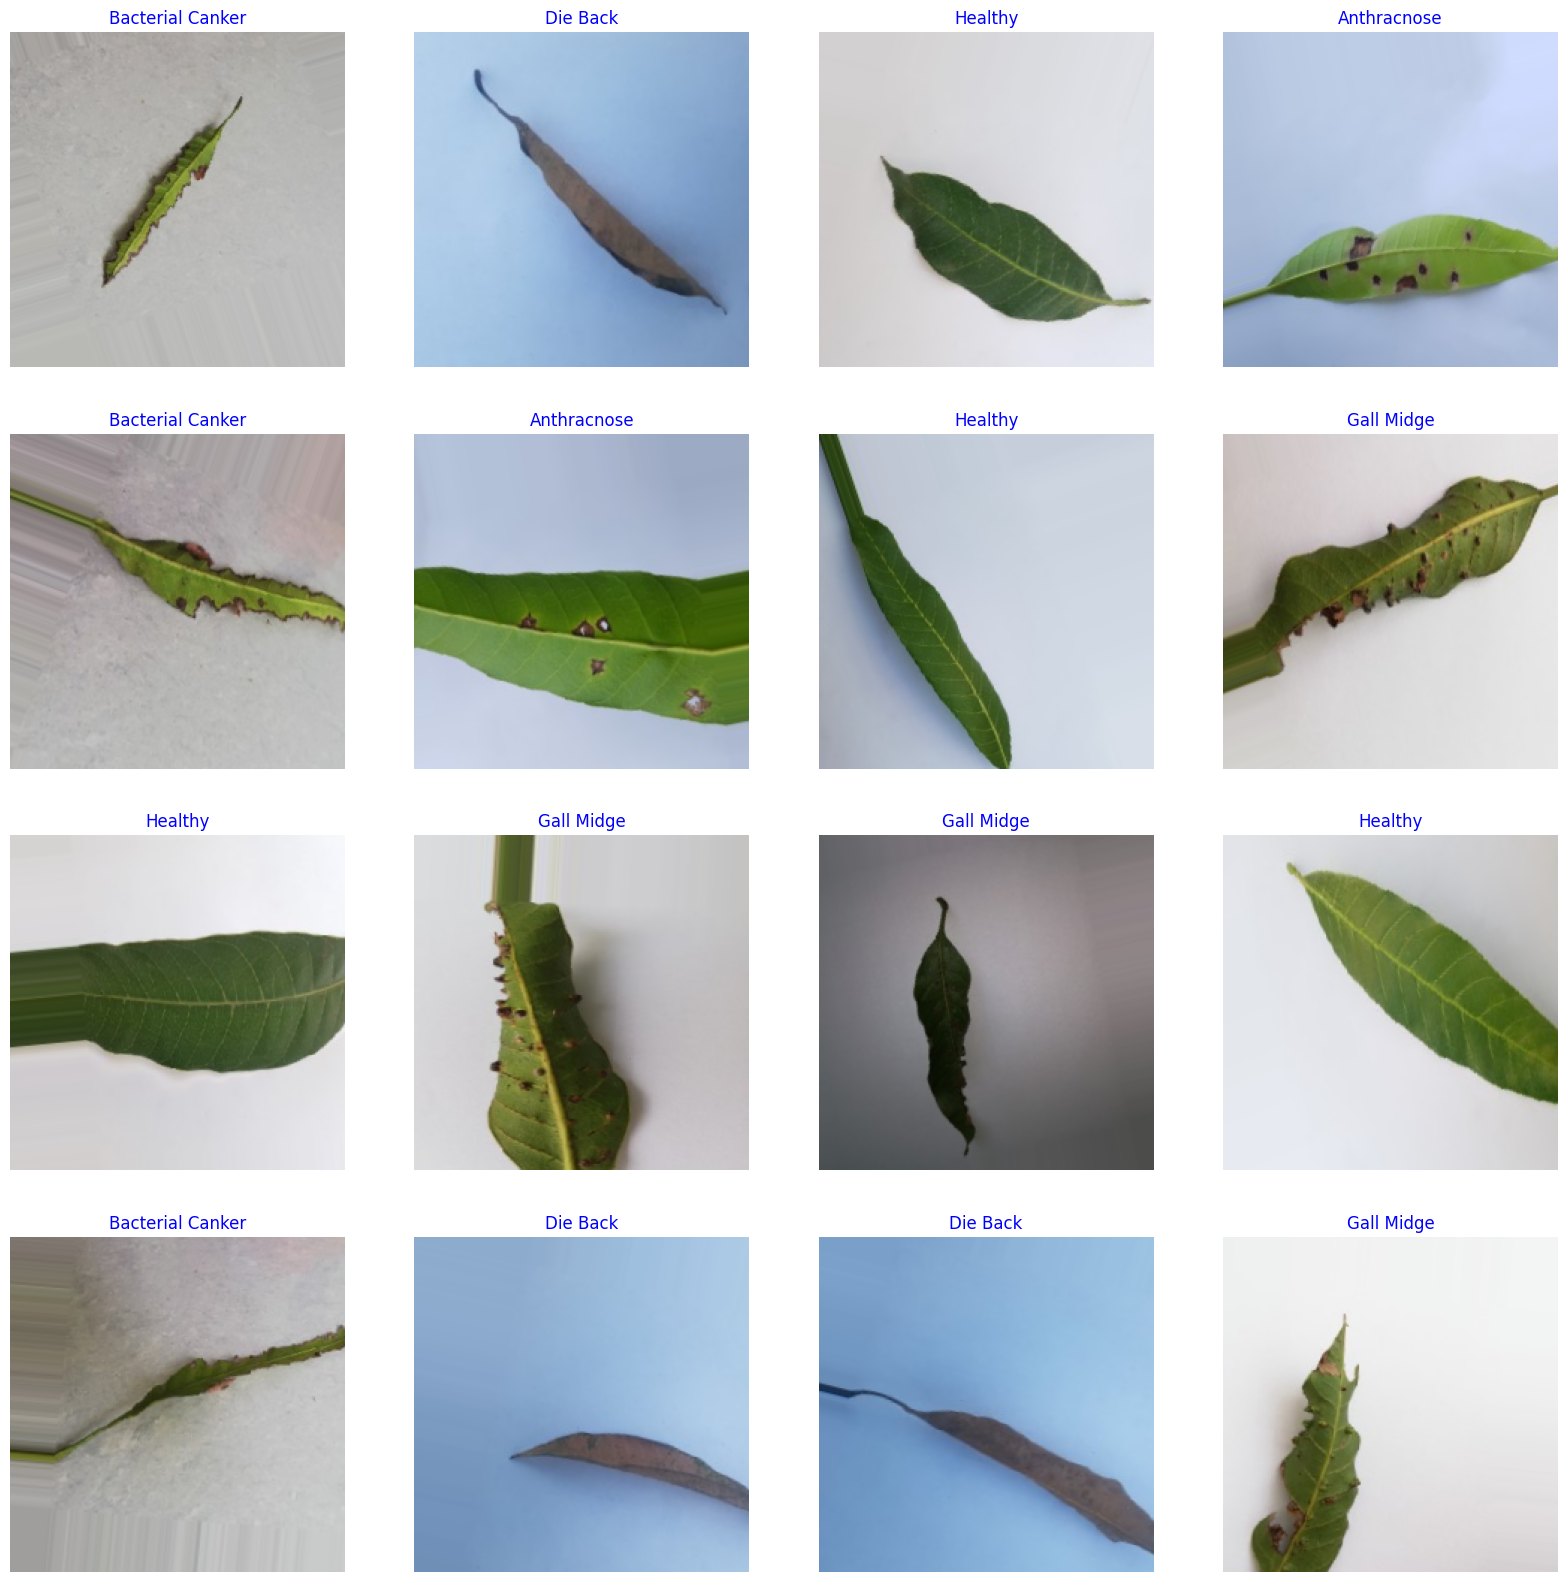

In [20]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [21]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

## **CNN Model Type1: EfficientNetB0**

![](https://www.researchgate.net/publication/351057828/figure/fig2/AS:1022512410394634@1620797364891/The-structure-of-an-EfficientNetB0-model-with-the-internal-structure-of-MBConv1-and.png)

In [22]:
# # Load the pre-trained EfficientNetB0 model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 4384169 (16.72 MB)
Trainable params: 43395

## **CNN Model Type2: ResNet50**

![](https://miro.medium.com/v2/resize:fit:1400/0*9LqUp7XyEx1QNc6A.png)

In [33]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization

# Load the pre-trained ResNet50 model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

# Create a Sequential model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_3 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 24121990 (92.02 MB)
Trainable params: 24064774 (91.80 MB)
Non-trainable params: 57216 (223.50 KB)
________

## **CNN Model Type3: (Custom Deep Learning Network) LeNet-5 with Average Pooling**

![](https://files.codingninjas.in/article_images/lenet-5-cnn-architecture-6-1675824240.webp)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

# Define LeNet-5 architecture with average pooling
model = Sequential([
    Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=img_shape, padding='same'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Flatten(),
    Dense(120, activation='tanh'),
    Dense(84, activation='tanh'),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 112, 112, 6)       0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 16)      2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 54, 54, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense_4 (Dense)             (None, 120)              

## **CNN Model Type4: (Custom Deep Learning Network) LeNet-5 with Max Pooling**

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define LeNet-5 architecture with max pooling
model = Sequential([
    Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=img_shape, padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Flatten(),
    Dense(120, activation='tanh'),
    Dense(84, activation='tanh'),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 6)       0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 108, 108, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_7 (Dense)             (None, 120)              

## **CNN Model Type5: (Custom Deep Learning Network) LeNet-5 with ReLU Activation Function**

In [26]:
# https://www.tensorflow.org/api_docs/python/tf/keras/activations

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define LeNet-5 architecture with max pooling
model = Sequential([
    Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=img_shape, padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 6)       456       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 16)      2416      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 16)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_10 (Dense)            (None, 120)              

## **CNN Model Type6: (Custom Deep Learning Network) VGG16 (Oxford U. Model)**

Reference: https://www.robots.ox.ac.uk/~vgg/

![](https://miro.medium.com/v2/resize:fit:1400/1*NNifzsJ7tD2kAfBXt3AzEg.png)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define VGG-like architecture
model = Sequential([
    # Block 1
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Block 2
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Block 3
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Block 4
    Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Block 5
    Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                 

## **Homework**


**Homework 1: Create deep learning architecture from the provided table (see at Assignment Document)**

Assignment Specifications:

*   Given the following table describing a deep learning architecture, design and implement the corresponding neural network using TensorFlow2.

In [30]:
## PLEASE INSERT YOUR CODE HERE

**Homework 2:  Create your own deep-learning network**

Assignment Specifications:

*   Design and implement your custom deep learning architecture for a given classification task.


In [31]:
## PLEASE INSERT YOUR CODE HERE

## **Train the model while implementing EarlyStopping.**

![](https://miro.medium.com/v2/resize:fit:1400/1*06sTlOC3AYeZAjzUDwbaMw@2x.jpeg)

![](https://mljar.com/blog/xgboost-early-stopping/optimal_number_of_trees.png)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 16 # set batch size for training
epochs = 5 # number of all epochs in training

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Add ModelCheckpoint callback to save the model weights
model_checkpoint = ModelCheckpoint('cnn_mango_leaf_best_model.h5', save_best_only=True)

history = model.fit(x=train_gen, epochs=epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
36/36 [==============================] - 53s 497ms/step - loss: 8.7925 - accuracy: 0.7695 - val_loss: 36.5454 - val_accuracy: 0.1649
Epoch 2/5
36/36 [==============================] - 11s 309ms/step - loss: 7.6616 - accuracy: 0.9007 - val_loss: 10.4449 - val_accuracy: 0.2021
Epoch 3/5
36/36 [==============================] - 11s 310ms/step - loss: 6.8699 - accuracy: 0.9433 - val_loss: 7.0636 - val_accuracy: 0.8511
Epoch 4/5
36/36 [==============================] - 12s 335ms/step - loss: 6.3583 - accuracy: 0.9557 - val_loss: 6.9716 - val_accuracy: 0.7447
Epoch 5/5
36/36 [==============================] - 12s 324ms/step - loss: 5.8728 - accuracy: 0.9610 - val_loss: 6.3440 - val_accuracy: 0.8245


#### **Display model performance**

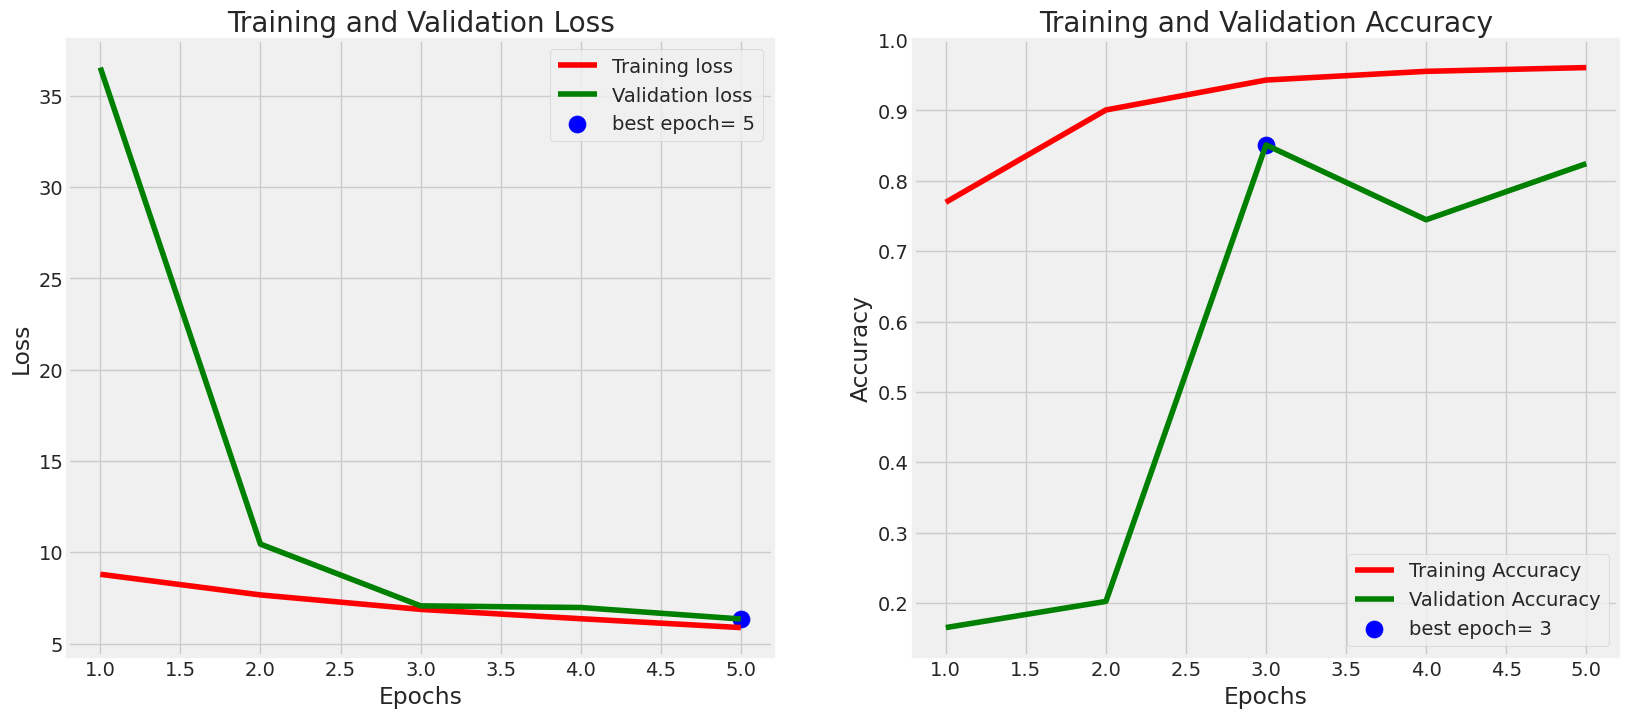

In [35]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [36]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

3/3 [==============================] - 5s 214ms/step - loss: 6.1820 - accuracy: 0.8466
Train Loss:  6.58506441116333
Train Accuracy:  0.7291666865348816
--------------------
Validation Loss:  6.051281452178955
Validation Accuracy:  0.9166666865348816
--------------------
Test Loss:  6.182028770446777
Test Accuracy:  0.8465608358383179


# **Get Predictions**

In [38]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **Confusion Matrics and Classification Report**

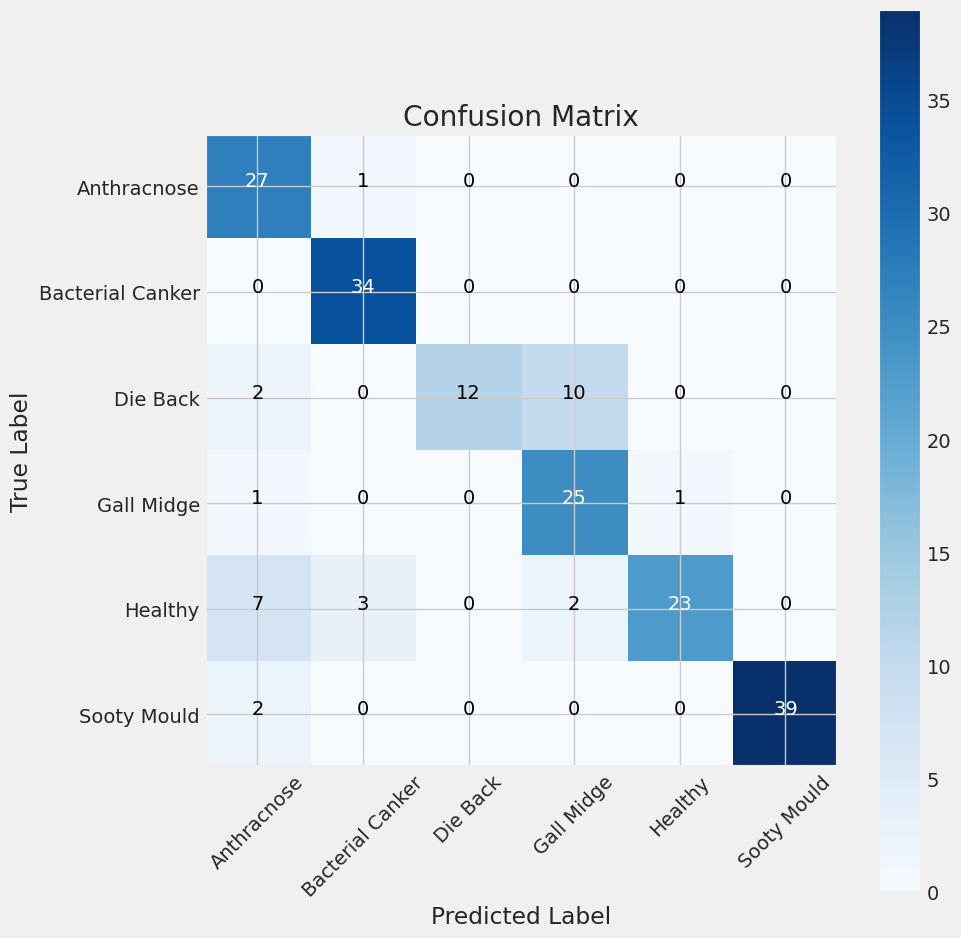

In [39]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [40]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

     Anthracnose       0.69      0.96      0.81        28
Bacterial Canker       0.89      1.00      0.94        34
        Die Back       1.00      0.50      0.67        24
      Gall Midge       0.68      0.93      0.78        27
         Healthy       0.96      0.66      0.78        35
     Sooty Mould       1.00      0.95      0.97        41

        accuracy                           0.85       189
       macro avg       0.87      0.83      0.83       189
    weighted avg       0.88      0.85      0.84       189



#### **Save model**

In [41]:
model_name = model.input_names[0][:-6]
subject = 'Mango Diseases'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as resnet50-Mango Diseases-84.66.h5
weights were saved as resnet50-Mango Diseases-weights.h5


#### **Generate CSV files containing classes indicies & image size**

In [42]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as Mango Diseases-class_dict.csv


## **Deployment Process**

![](https://1.bp.blogspot.com/-4C_bx62kOI4/XfE3XQT422I/AAAAAAAABmY/AbMfOO8yzjctmg30IcgOBaU5UmcZNpAtwCLcBGAsYHQ/s1600/model.png)

In [43]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import os, io

In [53]:
# Load your pre-trained model
model = load_model('/content/cnn_mango_leaf_best_model.h5')

In [56]:
# Get value counts
value_counts = df['labels'].value_counts()

# Create class indices dictionary
class_indices = {idx: label for idx, label
                  in enumerate(value_counts.index)}
class_indices

{0: 'Die Back',
 1: 'Bacterial Canker',
 2: 'Sooty Mould',
 3: 'Healthy',
 4: 'Gall Midge',
 5: 'Anthracnose'}

In [55]:
# Define allowed extensions for uploaded files
ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg', 'gif'}

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

# Define upload function
def on_upload_change(change):
    with upload_output:
        upload_output.clear_output()
        for name, file_info in uploader.value.items():
            if allowed_file(name):
                data = file_info['content']
                img = image.load_img(io.BytesIO(data), target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                # Normalization
                img_array /= 255.

                # Predict
                predictions = model.predict(img_array)

                predicted_class_index = np.argmax(predictions)
                predicted_class = class_indices[predicted_class_index]
                confidence = predictions[0][predicted_class_index]

                # Display the image with prediction and confidence score
                plt.imshow(img)
                plt.axis('off')
                plt.title(f'Prediction: {predicted_class}, Confidence: {confidence}')
                plt.show()

# Create upload button and output widget
uploader = widgets.FileUpload(accept='image/*', multiple=False)
upload_output = widgets.Output()

# Handle upload button changes
uploader.observe(on_upload_change, names='_counter')

# Display upload button and output widget
display(uploader, upload_output)

FileUpload(value={}, accept='image/*', description='Upload')

Output()